<a href="https://colab.research.google.com/github/BuberDev/Artificial-Intelligence-ComputerVision/blob/main/Klasyfikator_binarny_Drone_vs_Passenger_Plane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Import bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.set_printoptions(precision=12, suppress=True, linewidth=120)


## 2. Zaladowanie danych

In [2]:
!wget https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip

--2023-07-04 21:24:01--  https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.172.128, 74.125.126.128, 74.125.70.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.172.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540232238 (1.4G) [application/x-zip-compressed]
Saving to: ‘flying-vehicles.zip’

flying-vehicles.zip 100%[===================>]   1.43G  33.5MB/s    in 46s     

2023-07-04 21:24:48 (31.6 MB/s) - ‘flying-vehicles.zip’ saved [1540232238/1540232238]



In [3]:
!unzip -q flying-vehicles.zip

Przygotowanie zbiorow: treningowego, walidacyjnego i testowego

In [4]:
base_dir = './data/planes'
raw_no_of_files = {}
classes = ['drone', 'fighter-jet', 'helicopter', 'missile', 'passenger-plane', 'rocket']

# Ponizszy fragment kodu sprawdzi nam ile mamy zdiec dla poszczegolnych klass (tych wyzej)
for dir in classes:
  raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))

raw_no_of_files.items()

dict_items([('drone', 1332), ('fighter-jet', 1867), ('helicopter', 1387), ('missile', 1334), ('passenger-plane', 1424), ('rocket', 1186)])

In [5]:
from IPython.lib.display import exists
# Torzymy katalog images
data_dir = './images'

# Jesli taki katelolg nie istnieje to tworzymy go
if not os.path.exists( data_dir):
  os.mkdir(data_dir)

# Nastepnie utworzymy sobie odpowiednio sciezki do katalogow gdzie bedziemy miec zbory trenigowy, wal i test
# Np teraz dzieki metodzie 'join' polaczymy sciezke katalogu 'data_dir' z nowo utworzonym katalogiem 'train'

train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

# Teraz tworzemy kolejny poziom zagniezdzenia katalogow. Tym razem dla dwoch klass (klasyfikator binarny). Drony i samoloty pasazerskie

train_drone_dir = os.path.join(train_dir, 'drone')
train_passenger_dir = os.path.join(train_dir, 'passenger')

valid_drone_dir = os.path.join(valid_dir, 'drone')
valid_passenger_dir = os.path.join(valid_dir, 'passenger')

test_drone_dir = os.path.join(test_dir, 'drone')
test_passenger_dir = os.path.join(test_dir, 'passenger')

# Tworzymy teraz petle ktora przejdzie nam po 3 katalogach z 2 poziomu i jesli jakis nie istnieje to utworzy go
for directory in (train_dir, valid_dir, test_dir):
  if not os.path.exists(directory):
    os.mkdir(directory)

# To samo robimy dla tych kolejnych katalogow z 3 poziomu
dirs = [train_drone_dir, train_passenger_dir, valid_drone_dir, valid_passenger_dir, test_drone_dir, test_passenger_dir]

for dir in dirs:
  if not os.path.exists(dir):
    os.mkdir(dir)


In [9]:
# Teraz musimy stworzyc pelne sciezki do naszych plikow po niewaz chcemy je przekopiowac
# Do zmiennej 'drone_filenames' przypiszemy sobie wylistowanie plikow z katalodu 'drone'

drone_fnames = os.listdir(os.path.join(base_dir, 'drone'))
passenger_fnames = os.listdir(os.path.join(base_dir, 'passenger-plane'))

# Teraz przeprowadzimy proces , w ktorym wybierzemy z tych katalogow tylko te pliki ktorych koncowki/rozszerzenie konczy sie na 'jpg', 'png', 'jpeg'
drone_fnames = [fname for fname in drone_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
passenger_fnames = [fname for fname in passenger_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]


In [11]:
# Okreslamy teraz rozmiar danych, ktore bedziemy potrzebowac do naszego modelu
size = min(len(drone_fnames), len(passenger_fnames))
train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

# To 3 zmienne beda pomocne przy kopiowaniu
train_idx = train_size
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size

In [12]:
# Kopiujemy pliki

for i, fname in enumerate(drone_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(train_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(valid_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(test_drone_dir, fname)
        shutil.copyfile(src, dst)

for i, fname in enumerate(passenger_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(train_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(valid_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(test_passenger_dir, fname)
        shutil.copyfile(src, dst)

print('drone - zbiór treningowy', len(os.listdir(train_drone_dir)))
print('drone - zbiór walidacyjny', len(os.listdir(valid_drone_dir)))
print('drone - zbiór testowy', len(os.listdir(test_drone_dir)))

print('passenger - zbiór treningowy', len(os.listdir(train_passenger_dir)))
print('passenger - zbiór walidacyjny', len(os.listdir(valid_passenger_dir)))
print('passenger - zbiór testowy', len(os.listdir(test_passenger_dir)))


drone - zbiór treningowy 919
drone - zbiór walidacyjny 262
drone - zbiór testowy 131
passenger - zbiór treningowy 919
passenger - zbiór walidacyjny 262
passenger - zbiór testowy 131


# 3. Eksploracja danych

(-0.5, 999.5, 598.5, -0.5)

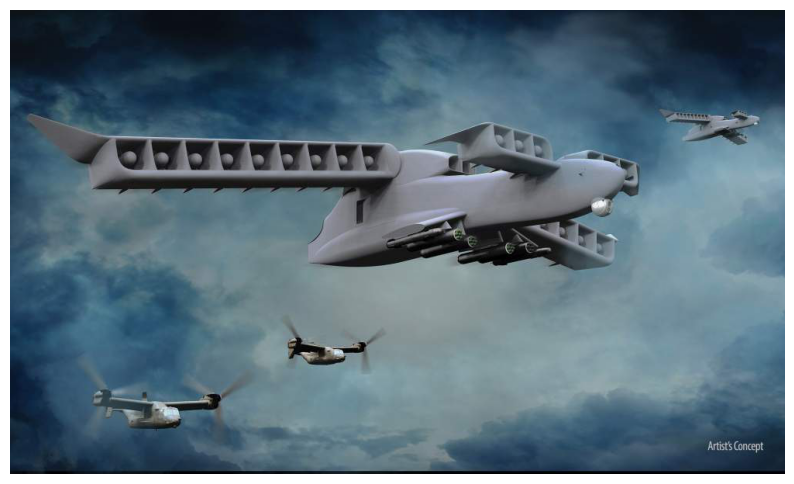

In [13]:

#@title Wybierz indeks przykładowego zdjęcia drona ze zbioru treningowego:

idx = 694 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(drone_fnames))
img_path = os.path.join(train_drone_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 1199.5, 1599.5, -0.5)

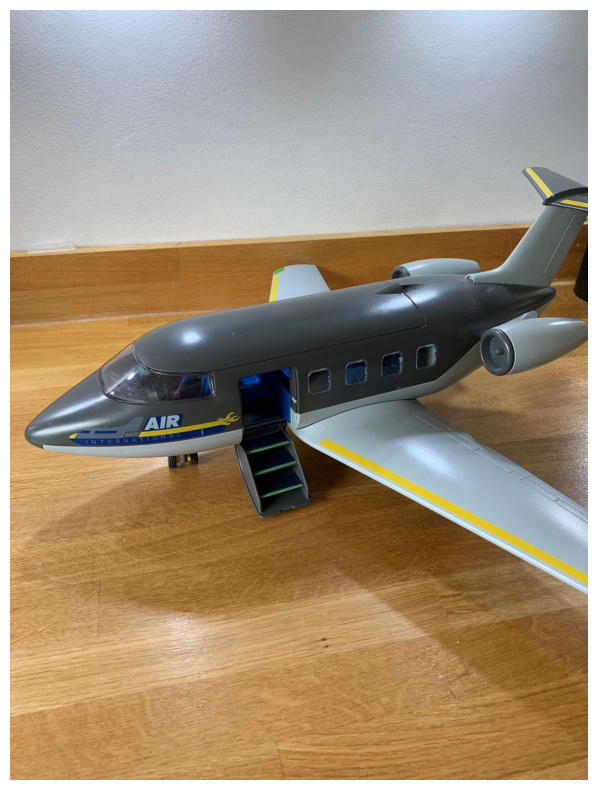

In [14]:

#@title Wybierz indeks przykładowego zdjęcia samolotu pasażerskiego ze zbioru treningowego:

idx = 699 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(passenger_fnames))
img_path = os.path.join(train_passenger_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

## Augumentacja danych


In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=40,     # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2, # poziome przekształcenia obrazu
    shear_range=0.2,        # zares losowego przycianania obrazu
    zoom_range=0.2,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'     # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)

# przeskalowujemy wszystkie obrazy o współczynnik 1/255
valid_datagen = ImageDataGenerator(rescale=1./255.)

# flow_from_directory pozwala nam ladowoac dane prosto z naszego katalogu
# Bilblioteka keras wywnioskuje ze w tym katalogu sa foldery "drone" oraz "passenger" i uzna je za docelowe klasy
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=(150, 150),# zdiecia maja rozne rozmiary dlatego przedlozenie ich do sici musimy je wystandaryzowac
                                                   batch_size=32,
                                                   class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

Found 1838 images belonging to 2 classes.
Found 524 images belonging to 2 classes.
